Ler com calma antes de avançar pois é preciso fazer algum tratamento do dataset antes de avançar para a fase 3 (machine learning). Tentei documentar tudo com os objetivos do código e problemas que surgiram. Como temos pouco tempo, penso que na parte de ML podemos usar apenas este dataset - dividindo-o em treino / teste (em vez de estar a fazer o pre-processamento e integração com as features do capela novamente para o ficheiro test.csv)
---
objetivo :  prever a classificação da termoestabilidade da proteína (conforme medido pelo ponto de fusão, tm)*Em resumo - o que falta?*
ANALISE EXPLORATÓRIA (PARTE 1)
- descrever de forma breve o significado das variáveis (o capela tem isso na documentação? as variáveis do challenge estão explicadas no site)
- escolher quais as variáveis muito correlacionadas a eliminar (de acordo com significado biologico)
- alterar graficos para ficarem bonitinhos e escrever interpretação
- t-test das médias para as nossas features (variáveis contínuas) versus tm alto/baixo
- confirmar que a ordem pela qual o código está feito é a mais correta
- *opcional*: teste de shapiro (normalidade) antes de fazer normalização (neste momento só temos histogramas para visualizar os dados / análise qualitativa)

ANÁLISE NÃO SUPERVISIONADA (PARTE 2)
- erros nos gráficos de visualização de clustering
- experimentar diferentes valores de "n" nos algoritmos
- interpretar gráficos e alterá-los para ficarem bonitos na apresentação
- reduzir dimensionalidade do dataset com base na interpretação dos gráficos


In [ ]:
import pandas as pd
import scipy.cluster.hierarchy
import seaborn as sn
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.feature_selection import SelectKBest, VarianceThreshold
from sklearn.feature_selection import r_regression
from scipy import stats
from scipy.stats import shapiro, levene, mannwhitneyu, ttest_ind
from statsmodels.stats.weightstats import ztest as ztest
from scipy.cluster.hierarchy import dendrogram, linkage
import matplotlib.pyplot as plt
%matplotlib inline

In [189]:
train = pd.read_csv("C:/Users/sonia/Downloads/SIB_Trabalho-main-master/kag/train.csv", delimiter=',')
test = pd.read_csv("C:/Users/sonia/Downloads/SIB_Trabalho-main-master/kag/test.csv", delimiter=',')
updates = pd.read_csv("C:/Users/sonia/Downloads/SIB_Trabalho-main-master/kag/train_updates_20220929.csv")

In [190]:
train

,seq_id,protein_sequence,pH,data_source,tm
0,0,AAAAKAAALALLGEAPEVVDIWLPAGWRQPFRVFRLERKGDGVLVG...,7.0,doi.org/10.1038/s41592-020-0801-4,75.7
1,1,AAADGEPLHNEEERAGAGQVGRSLPQESEEQRTGSRPRRRRDLGSR...,7.0,doi.org/10.1038/s41592-020-0801-4,50.5
2,2,AAAFSTPRATSYRILSSAGSGSTRADAPQVRRLHTTRDLLAKDYYA...,7.0,doi.org/10.1038/s41592-020-0801-4,40.5
3,3,AAASGLRTAIPAQPLRHLLQPAPRPCLRPFGLLSVRAGSARRSGLL...,7.0,doi.org/10.1038/s41592-020-0801-4,47.2
4,4,AAATKSGPRRQSQGASVRTFTPFYFLVEPVDTLSVRGSSVILNCSA...,7.0,doi.org/10.1038/s41592-020-0801-4,49.5
...,...,...,...,...,...
31385,31385,YYMYSGGGSALAAGGGGAGRKGDWNDIDSIKKKDLHHSRGDEKAQG...,7.0,doi.org/10.1038/s41592-020-0801-4,51.8
31386,31386,YYNDQHRLSSYSVETAMFLSWERAIVKPGAMFKKAVIGFNCNVDLI...,7.0,doi.org/10.1038/s41592-020-0801-4,37.2
31387,31387,YYQRTLGAELLYKISFGEMPKSAQDSAENCPSGMQFPDTAIAHANV...,7.0,doi.org/10.1038/s41592-020-0801-4,64.6
31388,31388,YYSFSDNITTVFLSRQAIDDDHSLSLGTISDVVESENGVVAADDAR...,7.0,doi.org/10.1038/s41592-020-0801-4,50.7


In [191]:
updates

,seq_id,protein_sequence,pH,data_source,tm
0,69,NaN,NaN,NaN,NaN
1,70,NaN,NaN,NaN,NaN
2,71,NaN,NaN,NaN,NaN
3,72,NaN,NaN,NaN,NaN
4,73,NaN,NaN,NaN,NaN
...,...,...,...,...,...
2429,30738,NaN,NaN,NaN,NaN
2430,30739,NaN,NaN,NaN,NaN
2431,30740,NaN,NaN,NaN,NaN
2432,30741,NaN,NaN,NaN,NaN


In [192]:
test

,seq_id,protein_sequence,pH,data_source
0,31390,VPVNPEPDATSVENVAEKTGSGDSQSDPIKADLEVKGQSALPFDVD...,8,Novozymes
1,31391,VPVNPEPDATSVENVAKKTGSGDSQSDPIKADLEVKGQSALPFDVD...,8,Novozymes
2,31392,VPVNPEPDATSVENVAKTGSGDSQSDPIKADLEVKGQSALPFDVDC...,8,Novozymes
3,31393,VPVNPEPDATSVENVALCTGSGDSQSDPIKADLEVKGQSALPFDVD...,8,Novozymes
4,31394,VPVNPEPDATSVENVALFTGSGDSQSDPIKADLEVKGQSALPFDVD...,8,Novozymes
...,...,...,...,...
2408,33798,VPVNPEPDATSVENVILKTGSGDSQSDPIKADLEVKGQSALPFDVD...,8,Novozymes
2409,33799,VPVNPEPDATSVENVLLKTGSGDSQSDPIKADLEVKGQSALPFDVD...,8,Novozymes
2410,33800,VPVNPEPDATSVENVNLKTGSGDSQSDPIKADLEVKGQSALPFDVD...,8,Novozymes
2411,33801,VPVNPEPDATSVENVPLKTGSGDSQSDPIKADLEVKGQSALPFDVD...,8,Novozymes


In [193]:
#COPIADO DO FORUM DO CHALLENGE (código da carina dá erro)
#columns to update
col_to_update = ['protein_sequence', 'pH', 'tm']
#seq_id to update
to_update_id = list(updates[~updates.protein_sequence.isna()].seq_id)

#reduce updates df to only necessary rows
updates = updates[updates.seq_id.isin(to_update_id)].set_index('seq_id')

#update values on train df
train.loc[to_update_id, col_to_update] = updates[col_to_update].values

#check if updated
pd.concat([train[train.seq_id.isin(to_update_id)].set_index('seq_id'), updates], axis = 1)
train

,seq_id,protein_sequence,pH,data_source,tm
0,0,AAAAKAAALALLGEAPEVVDIWLPAGWRQPFRVFRLERKGDGVLVG...,7.0,doi.org/10.1038/s41592-020-0801-4,75.7
1,1,AAADGEPLHNEEERAGAGQVGRSLPQESEEQRTGSRPRRRRDLGSR...,7.0,doi.org/10.1038/s41592-020-0801-4,50.5
2,2,AAAFSTPRATSYRILSSAGSGSTRADAPQVRRLHTTRDLLAKDYYA...,7.0,doi.org/10.1038/s41592-020-0801-4,40.5
3,3,AAASGLRTAIPAQPLRHLLQPAPRPCLRPFGLLSVRAGSARRSGLL...,7.0,doi.org/10.1038/s41592-020-0801-4,47.2
4,4,AAATKSGPRRQSQGASVRTFTPFYFLVEPVDTLSVRGSSVILNCSA...,7.0,doi.org/10.1038/s41592-020-0801-4,49.5
...,...,...,...,...,...
31385,31385,YYMYSGGGSALAAGGGGAGRKGDWNDIDSIKKKDLHHSRGDEKAQG...,7.0,doi.org/10.1038/s41592-020-0801-4,51.8
31386,31386,YYNDQHRLSSYSVETAMFLSWERAIVKPGAMFKKAVIGFNCNVDLI...,7.0,doi.org/10.1038/s41592-020-0801-4,37.2
31387,31387,YYQRTLGAELLYKISFGEMPKSAQDSAENCPSGMQFPDTAIAHANV...,7.0,doi.org/10.1038/s41592-020-0801-4,64.6
31388,31388,YYSFSDNITTVFLSRQAIDDDHSLSLGTISDVVESENGVVAADDAR...,7.0,doi.org/10.1038/s41592-020-0801-4,50.7


In [ ]:
#obter os descritores - CARINA (não testámos)
#descriptors_df = ProteinDescritors(dataset= train ,  col= 'protein_sequence')
#descriptors_df.dataset
#descriptors_df.get_lenght(n_jobs=4)
#descriptors_df.get_aa_comp(n_jobs=4)
#descriptors_df
#all_descriptors = descriptors_df.get_all_physicochemical(ph=7, amide=False, n_jobs=4)
#all_descriptors
#all_descriptors.to_csv('descriptors.csv')

In [194]:
dataset = pd.read_csv("C:/Users/sonia/Downloads/SIB_Trabalho-main-master/kag/descriptors.csv", delimiter=';', header=0)

In [195]:
#tamanho e primeiras linhas
print (dataset.shape)
dataset.head()

#verificacao dos data types
data_types = dataset.dtypes
print(data_types)

#descrever o significado das variáveis

#sumarização de valores estatísticos gerais
dataset.describe()
#as variáveis têm valores em gamas muito diferentes, por isso será preciso fazer normalização dos dados

(28739, 30)
Unnamed: 0                                 int64
seq_id                                     int64
protein_sequence                          object
pH                                       float64
length                                   float64
charge                                   float64
chargedensity                            float64
formulaC                                   int64
formulaH                                   int64
formulaN                                   int64
formulaO                                   int64
formulaS                                   int64
tot                                        int64
hydrogen                                   int64
single                                     int64
double                                     int64
MW_modlamp                               float64
Gravy                                    float64
Aromacity                                float64
IsoelectricPoint                         float64
Instabil

,Unnamed: 0,seq_id,pH,length,charge,chargedensity,formulaC,formulaH,formulaN,formulaO,...,Instability_index,SecStruct_helix,SecStruct_turn,SecStruct_sheet,Molar_extinction_coefficient_reduced,Molar_extinction_coefficient_oxidized,aliphatic_index,bomanindex,hydrophobic_ratio,tm
count,28739.000000,28739.000000,28739.000000,28739.000000,28739.000000,28739.000000,28739.000000,28739.000000,28739.000000,28739.000000,...,28739.000000,28739.000000,28739.000000,28739.000000,28739.000000,28739.000000,28739.000000,28739.000000,28739.000000,28739.000000
mean,14369.000000,15545.248234,6.951551,461.012457,-5.313969,-0.000062,2258.002679,3541.273357,609.005915,711.923240,...,40.477407,0.296239,0.226101,0.267736,48028.957862,48425.448693,85.234561,1.683476,0.370748,49.350659
std,8296.379029,9224.897566,0.951033,430.562526,18.652624,0.000334,2085.418633,3274.813811,568.801797,685.215374,...,11.352726,0.044597,0.043856,0.048460,47705.473385,48142.209405,14.395127,0.551643,0.049421,13.731283
min,0.000000,0.000000,1.990000,5.000000,-903.437000,-0.002708,22.000000,40.000000,8.000000,7.000000,...,-7.383333,0.022727,0.030769,0.000000,0.000000,0.000000,0.000000,-1.661429,0.045977,0.000000
25%,7184.500000,7440.500000,7.000000,219.000000,-9.853500,-0.000232,1086.000000,1700.000000,290.000000,334.000000,...,33.358050,0.274854,0.199166,0.237401,19940.000000,20190.000000,77.061510,1.386256,0.342857,42.300000
50%,14369.000000,15188.000000,7.000000,356.000000,-3.347000,-0.000082,1751.000000,2745.000000,469.000000,541.000000,...,39.665278,0.299758,0.222222,0.265957,35300.000000,35450.000000,85.596817,1.660613,0.372727,48.000000
75%,21553.500000,23694.500000,7.000000,544.000000,3.029000,0.000086,2687.000000,4182.000000,718.000000,833.000000,...,46.754319,0.319873,0.246106,0.293698,60390.000000,61030.000000,94.006806,1.981683,0.399216,53.500000
max,28738.000000,31389.000000,64.900000,8798.000000,396.696000,0.002890,43327.000000,68830.000000,11684.000000,14709.000000,...,141.642748,0.632653,0.747126,0.579832,920160.000000,928160.000000,194.285714,5.281972,0.637681,130.000000


In [196]:
#confirmar que não há dados omissos (código anterior já tinha algum tratamento de NAs - ver)
dataset.isnull().sum().sum() #output: não há dados omissos


0

In [197]:
#perceber se há colunas com todos os valores iguais (variância = zero)
dataset.var(axis=0)
#aqui também se pode criar um threshold e eliminar columas com variancia inferior a um valor

C:\Users\sonia\AppData\Local\Temp\ipykernel_19492\2550334465.py:2: FutureWarning: The default value of numeric_only in DataFrame.var is deprecated. In a future version, it will default to False. In addition, specifying 'numeric_only=None' is deprecated. Select only valid columns or specify the value of numeric_only to silence this warning.
  dataset.var(axis=0)


Unnamed: 0                               6.882990e+07
seq_id                                   8.509874e+07
pH                                       9.044631e-01
length                                   1.853841e+05
charge                                   3.479204e+02
chargedensity                            1.117612e-07
formulaC                                 4.348971e+06
formulaH                                 1.072441e+07
formulaN                                 3.235355e+05
formulaO                                 4.695201e+05
formulaS                                 3.406342e+02
tot                                      0.000000e+00
hydrogen                                 0.000000e+00
single                                   0.000000e+00
double                                   0.000000e+00
MW_modlamp                               2.310338e+09
Gravy                                    1.018051e-01
Aromacity                                6.410086e-04
IsoelectricPoint            

In [212]:
#eliminar as colunas que têm todos os valores iguais (carina) <<<< pode ser feito com o variancethreshold!!
df = dataset.drop(columns=['tot', 'hydrogen', 'single', 'double'], axis=1)

In [213]:
#eliminar linhas duplicadas
df = df.drop_duplicates(subset = "seq_id")

array([[<AxesSubplot: title={'center': 'Unnamed: 0'}>,
        <AxesSubplot: title={'center': 'seq_id'}>,
        <AxesSubplot: title={'center': 'pH'}>,
        <AxesSubplot: title={'center': 'length'}>,
        <AxesSubplot: title={'center': 'charge'}>],
       [<AxesSubplot: title={'center': 'chargedensity'}>,
        <AxesSubplot: title={'center': 'formulaC'}>,
        <AxesSubplot: title={'center': 'formulaH'}>,
        <AxesSubplot: title={'center': 'formulaN'}>,
        <AxesSubplot: title={'center': 'formulaO'}>],
       [<AxesSubplot: title={'center': 'formulaS'}>,
        <AxesSubplot: title={'center': 'MW_modlamp'}>,
        <AxesSubplot: title={'center': 'Gravy'}>,
        <AxesSubplot: title={'center': 'Aromacity'}>,
        <AxesSubplot: title={'center': 'IsoelectricPoint'}>],
       [<AxesSubplot: title={'center': 'Instability_index'}>,
        <AxesSubplot: title={'center': 'SecStruct_helix'}>,
        <AxesSubplot: title={'center': 'SecStruct_turn'}>,
        <AxesSubpl

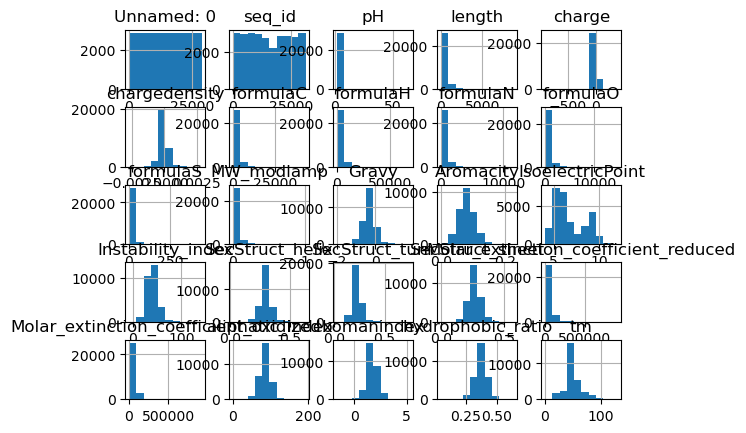

In [214]:
#visualização rápida de histograma de todas as variáveis, a maior parte não parece seguir distribuição normal
df.hist()
#para apresentação, o histograma precisa de ser melhorado (legendas, etc)
#as primeiras variáveis (seq_id, unnamed) não deverão ser usadas

#testar normalidade dos dados quantitativamente com o teste shapiro - COMO FAZER? DEU SEMPRE ERRO

In [215]:
#separar X e Y (carina) - porquê fazer aqui e não mais tarde? porque é que o X não inclui a info da sequência?
X = df.iloc[:, 3:-1]
Y = df.iloc[:, -1]

In [216]:
#visualizar X
X


,pH,length,charge,chargedensity,formulaC,formulaH,formulaN,formulaO,formulaS,MW_modlamp,...,IsoelectricPoint,Instability_index,SecStruct_helix,SecStruct_turn,SecStruct_sheet,Molar_extinction_coefficient_reduced,Molar_extinction_coefficient_oxidized,aliphatic_index,bomanindex,hydrophobic_ratio
0,7.0,341.0,-1.732,-0.000048,1622,2623,447,473,9,36319.84,...,6.109589,28.389736,0.316716,0.211144,0.351906,26470,26470,102.991202,1.020440,0.454545
1,7.0,286.0,-12.537,-0.000382,1385,2224,412,490,2,32837.09,...,5.144349,65.108392,0.213287,0.160839,0.367133,20970,20970,72.062937,3.240490,0.297203
2,7.0,497.0,11.513,0.000215,2290,3559,669,760,15,53428.00,...,9.032101,35.089336,0.209256,0.267606,0.213280,40340,40840,54.245473,2.168934,0.301811
3,7.0,265.0,-20.606,-0.000699,1293,2006,338,428,7,29474.71,...,4.683840,50.502264,0.267925,0.215094,0.298113,22460,22710,78.792453,1.902415,0.343396
4,7.0,1451.0,-21.900,-0.000138,6948,10869,1869,2252,45,158761.55,...,5.917928,45.668808,0.271537,0.292901,0.206065,158030,158905,77.746382,1.684390,0.318401
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
28734,7.0,549.0,5.709,0.000092,2710,4196,774,829,25,61996.83,...,8.466327,48.604026,0.287796,0.242259,0.224044,98320,99070,75.792350,2.063898,0.336976
28735,7.0,469.0,-3.132,-0.000060,2342,3642,632,698,19,52636.87,...,6.532244,35.285096,0.324094,0.217484,0.270789,48360,48610,92.942431,1.389019,0.402985
28736,7.0,128.0,-2.866,-0.000202,626,936,158,198,8,14202.99,...,5.271214,44.198437,0.265625,0.250000,0.257812,27960,27960,62.578125,1.293672,0.367188
28737,7.0,593.0,-9.209,-0.000143,2832,4477,753,884,31,64367.10,...,5.688128,36.618398,0.288364,0.268128,0.259696,43320,43570,83.355818,1.334250,0.384486


In [217]:
#visualizar Y (neste momento é um panda series / array)
print(Y)

#converter Y para pandas dataframe, pois por vezes é mais fácil utilizar este formato
data_Y = Y.to_frame(name = "Y")
data_Y

0        75.7
1        50.5
2        40.5
3        47.2
4        49.5
         ... 
28734    51.8
28735    37.2
28736    64.6
28737    50.7
28738    37.6
Name: tm, Length: 28739, dtype: float64


,Y
0,75.7
1,50.5
2,40.5
3,47.2
4,49.5
...,...
28734,51.8
28735,37.2
28736,64.6
28737,50.7


In [218]:
#fazer normalização dos dados de X
scaler_st = StandardScaler().fit(X)
data_st = scaler_st.transform(X)

#sumariar os dados transformados (atenção que agora é array numpy e não panda dataframe)
np.set_printoptions(precision = 3)
print(data_st[0:5,:])

#converter de novo a panda dataframe (dá mais jeito assim, não é?)
data_scale_X =  pd.DataFrame(data_st, index =X.index , columns = X.columns)
data_scale_X

#sumariar estatísticas
data_scale_X.describe()

[[ 5.094e-02 -2.787e-01  1.920e-01  4.171e-02 -3.050e-01 -2.804e-01
  -2.848e-01 -3.487e-01 -4.586e-01 -3.144e-01  1.496e+00 -8.642e-01
  -3.805e-01 -1.065e+00  4.591e-01 -3.411e-01  1.737e+00 -4.519e-01
  -4.561e-01  1.234e+00 -1.202e+00  1.696e+00]
 [ 5.094e-02 -4.065e-01 -3.872e-01 -9.577e-01 -4.186e-01 -4.023e-01
  -3.464e-01 -3.239e-01 -8.379e-01 -3.869e-01 -2.383e+00 -1.524e+00
  -9.509e-01  2.170e+00 -1.860e+00 -1.488e+00  2.051e+00 -5.672e-01
  -5.703e-01 -9.150e-01  2.823e+00 -1.488e+00]
 [ 5.094e-02  8.358e-02  9.021e-01  8.289e-01  1.534e-02  5.413e-03
   1.055e-01  7.016e-02 -1.335e-01  4.150e-02 -1.195e+00 -1.893e-03
   1.347e+00 -4.746e-01 -1.950e+00  9.464e-01 -1.124e+00 -1.612e-01
  -1.576e-01 -2.153e+00  8.800e-01 -1.395e+00]
 [ 5.094e-02 -4.553e-01 -8.198e-01 -1.907e+00 -4.627e-01 -4.688e-01
  -4.765e-01 -4.144e-01 -5.670e-01 -4.569e-01 -5.599e-01 -3.489e-01
  -1.223e+00  8.831e-01 -6.349e-01 -2.510e-01  6.269e-01 -5.360e-01
  -5.342e-01 -4.475e-01  3.969e-01 -5.535e-

,pH,length,charge,chargedensity,formulaC,formulaH,formulaN,formulaO,formulaS,MW_modlamp,...,IsoelectricPoint,Instability_index,SecStruct_helix,SecStruct_turn,SecStruct_sheet,Molar_extinction_coefficient_reduced,Molar_extinction_coefficient_oxidized,aliphatic_index,bomanindex,hydrophobic_ratio
count,2.873900e+04,2.873900e+04,2.873900e+04,2.873900e+04,2.873900e+04,2.873900e+04,2.873900e+04,2.873900e+04,2.873900e+04,2.873900e+04,...,2.873900e+04,2.873900e+04,2.873900e+04,2.873900e+04,2.873900e+04,2.873900e+04,2.873900e+04,2.873900e+04,2.873900e+04,2.873900e+04
mean,1.157083e-16,4.549214e-17,-1.433991e-17,-1.186751e-17,3.263567e-17,2.818535e-17,5.884310e-17,-3.189395e-17,-2.126263e-17,2.071870e-16,...,-3.599813e-16,-3.678930e-16,1.190707e-15,1.780127e-16,4.351422e-16,-4.351422e-17,-5.735966e-17,1.226804e-15,3.105333e-16,2.991603e-16
std,1.000017e+00,1.000017e+00,1.000017e+00,1.000017e+00,1.000017e+00,1.000017e+00,1.000017e+00,1.000017e+00,1.000017e+00,1.000017e+00,...,1.000017e+00,1.000017e+00,1.000017e+00,1.000017e+00,1.000017e+00,1.000017e+00,1.000017e+00,1.000017e+00,1.000017e+00,1.000017e+00
min,-5.217105e+00,-1.059127e+00,-4.815079e+01,-7.917032e+00,-1.072227e+00,-1.069170e+00,-1.056636e+00,-1.028779e+00,-9.462417e-01,-1.059097e+00,...,-1.597605e+00,-4.215866e+00,-6.133037e+00,-4.453971e+00,-5.524987e+00,-1.006798e+00,-1.005901e+00,-5.921174e+00,-6.063638e+00,-6.571620e+00
25%,5.094425e-02,-5.620941e-01,-2.433765e-01,-5.111033e-01,-5.620085e-01,-5.622626e-01,-5.608482e-01,-5.515489e-01,-5.669603e-01,-5.587313e-01,...,-7.969462e-01,-6.271164e-01,-4.795361e-01,-6.141835e-01,-6.260056e-01,-5.888097e-01,-5.865111e-01,-5.677751e-01,-5.388008e-01,-5.643644e-01
50%,5.094425e-02,-2.439002e-01,1.054545e-01,-6.170094e-02,-2.431222e-01,-2.431550e-01,-2.461461e-01,-2.494489e-01,-2.418620e-01,-2.468549e-01,...,-3.571744e-01,-7.153732e-02,7.890323e-02,-8.844907e-02,-3.671070e-02,-2.668285e-01,-2.695280e-01,2.516559e-02,-4.144638e-02,4.004624e-02
75%,5.094425e-02,1.927455e-01,4.472890e-01,4.404803e-01,2.057164e-01,1.956563e-01,1.916238e-01,1.767019e-01,1.916024e-01,1.937804e-01,...,9.796221e-01,5.529087e-01,5.299474e-01,4.561483e-01,5.357371e-01,2.591161e-01,2.618237e-01,6.094005e-01,5.405891e-01,5.760343e-01
max,6.093319e+01,1.936335e+01,2.155284e+01,8.830634e+00,1.969375e+01,1.993697e+01,1.947108e+01,2.042762e+01,2.305685e+01,1.993898e+01,...,3.100496e+00,8.911261e+00,7.543492e+00,1.188045e+01,6.440378e+00,1.828189e+01,1.827398e+01,7.575692e+00,6.523347e+00,5.401286e+00


In [ ]:
#será mesmo preciso esta linha de codigo que está sempre nos exercicios dos profs? já normalizamos antes supostamente
#ou será melhor fazer apenas este preprocessamente sem a normalização da célula de código anterior?
#data_scale = preprocessing.scale(iris.iloc[:,:4])

#confirmar mas depois de ler isto, parece-me que não é preciso https://towardsai.net/p/data-science/how-when-and-why-should-you-normalize-standardize-rescale-your-data-3f083def38ff


In [219]:
#correlação entre variáveis ---- aqui não inclui o Y (faz-se depois?)!!
corr_matrix = data_scale_X.corr()
#corr_matrix

#transformar em pandas dataframe (mais facil visualizaçao)
corr_dataframe = pd.DataFrame(corr_matrix)
corr_dataframe


,pH,length,charge,chargedensity,formulaC,formulaH,formulaN,formulaO,formulaS,MW_modlamp,...,IsoelectricPoint,Instability_index,SecStruct_helix,SecStruct_turn,SecStruct_sheet,Molar_extinction_coefficient_reduced,Molar_extinction_coefficient_oxidized,aliphatic_index,bomanindex,hydrophobic_ratio
pH,1.000000,0.012413,-0.026170,-0.127817,0.013363,0.012447,0.010793,0.010698,0.001170,0.012123,...,-0.129998,0.067457,0.024607,0.040893,0.025240,-0.002451,-0.002757,0.008056,-0.053055,0.001705
length,0.012413,1.000000,-0.509214,-0.133545,0.998779,0.998725,0.998537,0.998140,0.875966,0.999390,...,-0.141664,0.221563,-0.145833,0.130881,-0.020341,0.836082,0.838196,-0.095124,0.111823,-0.150437
charge,-0.026170,-0.509214,1.000000,0.611052,-0.506844,-0.501853,-0.492257,-0.533917,-0.420126,-0.510388,...,0.609883,-0.050752,0.047601,0.057354,-0.130251,-0.424229,-0.425497,0.026766,-0.052645,0.057371
chargedensity,-0.127817,-0.133545,0.611052,1.000000,-0.132815,-0.127395,-0.118161,-0.148362,-0.103832,-0.133433,...,0.885333,-0.030650,-0.040692,0.076594,-0.213483,-0.116153,-0.116179,-0.036021,0.058152,-0.012935
formulaC,0.013363,0.998779,-0.506844,-0.132815,1.000000,0.999620,0.998124,0.996641,0.874882,0.999614,...,-0.141288,0.217614,-0.121156,0.110355,-0.018321,0.848774,0.850696,-0.084006,0.109832,-0.142218
formulaH,0.012447,0.998725,-0.501853,-0.127395,0.999620,1.000000,0.998399,0.996719,0.872841,0.999482,...,-0.136123,0.218662,-0.124754,0.104192,-0.009292,0.838114,0.840072,-0.076246,0.113364,-0.137758
formulaN,0.010793,0.998537,-0.492257,-0.118161,0.998124,0.998399,1.000000,0.997166,0.873181,0.999002,...,-0.125846,0.233875,-0.155008,0.120267,-0.019048,0.836195,0.838254,-0.103960,0.140228,-0.163374
formulaO,0.010698,0.998140,-0.533917,-0.148362,0.996641,0.996719,0.997166,1.000000,0.867383,0.998317,...,-0.155814,0.231892,-0.166361,0.124727,-0.025078,0.827235,0.829298,-0.115624,0.143394,-0.177351
formulaS,0.001170,0.875966,-0.420126,-0.103832,0.874882,0.872841,0.873181,0.867383,1.000000,0.876185,...,-0.116759,0.205084,-0.127173,0.103052,-0.066369,0.765848,0.771405,-0.113601,0.053105,-0.069374
MW_modlamp,0.012123,0.999390,-0.510388,-0.133433,0.999614,0.999482,0.999002,0.998317,0.876185,1.000000,...,-0.141611,0.224654,-0.138583,0.115169,-0.020016,0.841569,0.843598,-0.095115,0.122842,-0.153459


<AxesSubplot: >

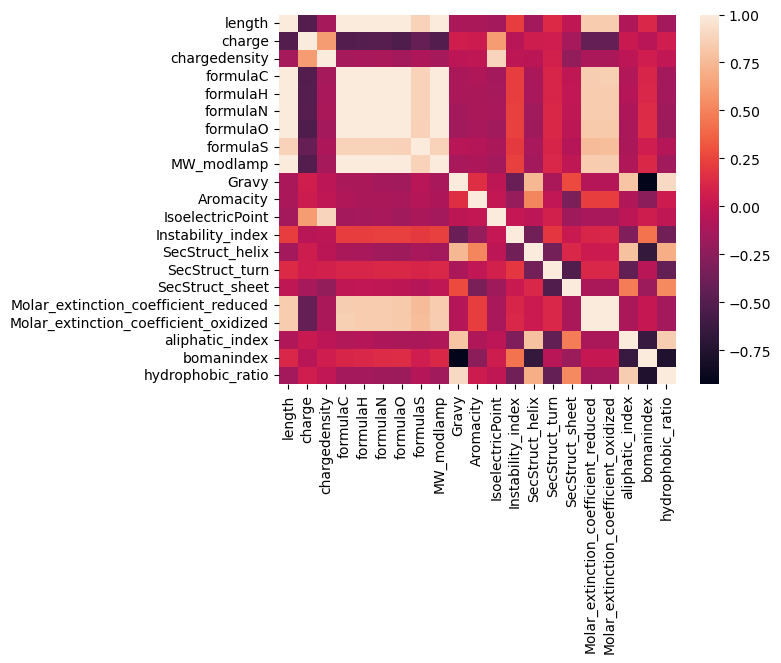

In [220]:
#heatmat de correlações entre variáveis - INTERPRETAR
#podemos ter valores se alterarmos para annot=True
sn.heatmap(corr_matrix.iloc[1:23,1:23], annot=False)
#plt.show()

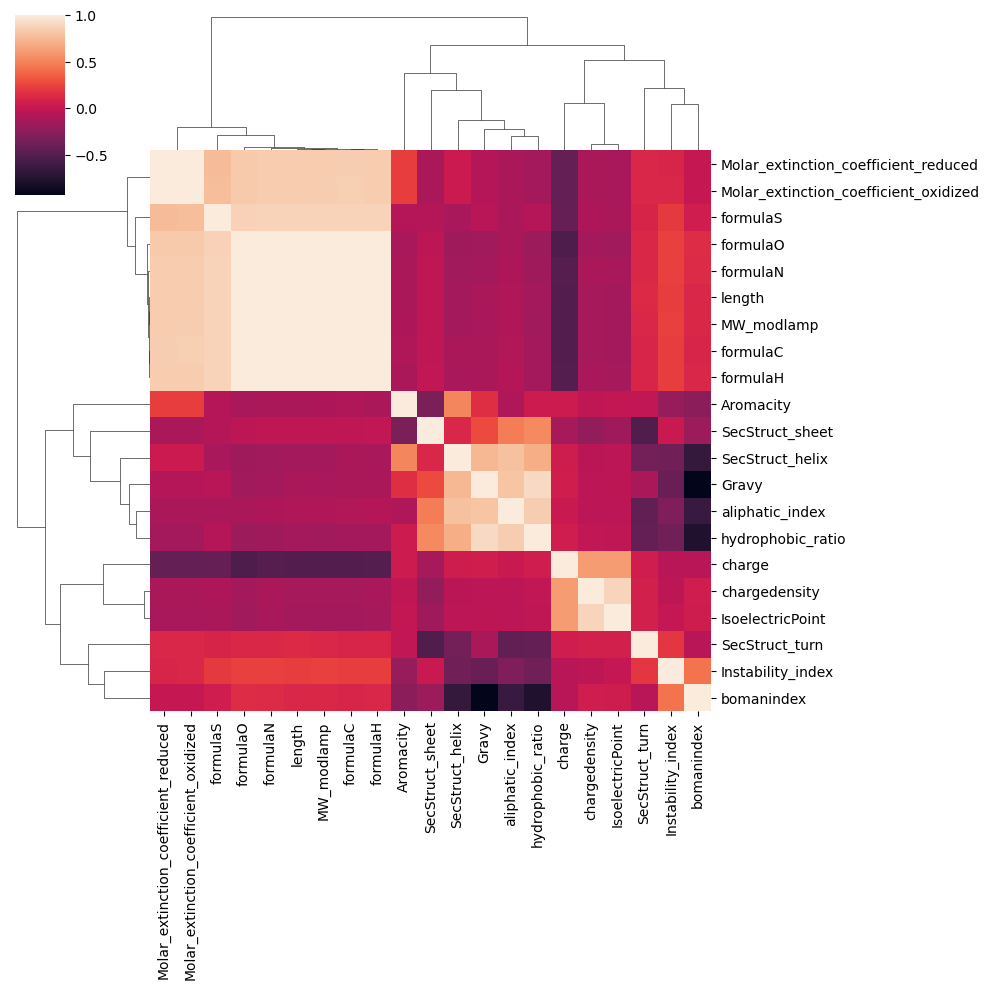

In [221]:
#clustermap / clustering hierárquico - INTERPRETAR
sn.clustermap(corr_matrix.iloc[1:23,1:23])

In [222]:
#correlação entre todas as variáveis, incluindo tm (= Y)
corr_matrix_all = pd.concat([data_scale_X, data_Y], axis=1).corr()
corr_matrix_all

#o Y tem sempre correlações inferiores a 0.25 com as outras variáveis

#idealmente deviamos eliminar as variáveis do X que estão muito correlacionadas entre si, porque não vão adicionar mais info à análise ----> justificar a sua correlação fazer sentido do ponto de vista biológico (por exemplo, as variáveis das fórmulas estão todas muito relacionadas entre si)

,pH,length,charge,chargedensity,formulaC,formulaH,formulaN,formulaO,formulaS,MW_modlamp,...,Instability_index,SecStruct_helix,SecStruct_turn,SecStruct_sheet,Molar_extinction_coefficient_reduced,Molar_extinction_coefficient_oxidized,aliphatic_index,bomanindex,hydrophobic_ratio,Y
pH,1.000000,0.012413,-0.026170,-0.127817,0.013363,0.012447,0.010793,0.010698,0.001170,0.012123,...,0.067457,0.024607,0.040893,0.025240,-0.002451,-0.002757,0.008056,-0.053055,0.001705,0.004650
length,0.012413,1.000000,-0.509214,-0.133545,0.998779,0.998725,0.998537,0.998140,0.875966,0.999390,...,0.221563,-0.145833,0.130881,-0.020341,0.836082,0.838196,-0.095124,0.111823,-0.150437,-0.076283
charge,-0.026170,-0.509214,1.000000,0.611052,-0.506844,-0.501853,-0.492257,-0.533917,-0.420126,-0.510388,...,-0.050752,0.047601,0.057354,-0.130251,-0.424229,-0.425497,0.026766,-0.052645,0.057371,0.049609
chargedensity,-0.127817,-0.133545,0.611052,1.000000,-0.132815,-0.127395,-0.118161,-0.148362,-0.103832,-0.133433,...,-0.030650,-0.040692,0.076594,-0.213483,-0.116153,-0.116179,-0.036021,0.058152,-0.012935,-0.011778
formulaC,0.013363,0.998779,-0.506844,-0.132815,1.000000,0.999620,0.998124,0.996641,0.874882,0.999614,...,0.217614,-0.121156,0.110355,-0.018321,0.848774,0.850696,-0.084006,0.109832,-0.142218,-0.075088
formulaH,0.012447,0.998725,-0.501853,-0.127395,0.999620,1.000000,0.998399,0.996719,0.872841,0.999482,...,0.218662,-0.124754,0.104192,-0.009292,0.838114,0.840072,-0.076246,0.113364,-0.137758,-0.073827
formulaN,0.010793,0.998537,-0.492257,-0.118161,0.998124,0.998399,1.000000,0.997166,0.873181,0.999002,...,0.233875,-0.155008,0.120267,-0.019048,0.836195,0.838254,-0.103960,0.140228,-0.163374,-0.072777
formulaO,0.010698,0.998140,-0.533917,-0.148362,0.996641,0.996719,0.997166,1.000000,0.867383,0.998317,...,0.231892,-0.166361,0.124727,-0.025078,0.827235,0.829298,-0.115624,0.143394,-0.177351,-0.085848
formulaS,0.001170,0.875966,-0.420126,-0.103832,0.874882,0.872841,0.873181,0.867383,1.000000,0.876185,...,0.205084,-0.127173,0.103052,-0.066369,0.765848,0.771405,-0.113601,0.053105,-0.069374,-0.118445
MW_modlamp,0.012123,0.999390,-0.510388,-0.133433,0.999614,0.999482,0.999002,0.998317,0.876185,1.000000,...,0.224654,-0.138583,0.115169,-0.020016,0.841569,0.843598,-0.095115,0.122842,-0.153459,-0.078068


In [223]:
#selecionar as features que têm correlação muito alta (superior a 0.8)
correlated_features = set()

for i in range(len(corr_matrix.columns)):
    for j in range(i):
        if abs(corr_matrix.iloc[i, j]) > 0.8:
            colname = corr_matrix.columns[i]
            correlated_features.add(colname)

len(correlated_features)
print(correlated_features)
#as features muito correlacionadas são: {'bomanindex', 'formulaH', 'formulaO', 'hydrophobic_ratio', 'Molar_extinction_coefficient_reduced', 'formulaC', 'IsoelectricPoint', 'formulaN', 'formulaS', 'Molar_extinction_coefficient_oxidized', 'MW_modlamp'}

#escolher quais destas eliminar (não temos necessariamente que eliminar todas, analisar a matriz, porque, por exemplo, se há apenas correlação entre duas, escolhe-se eliminar apenas uma e a outra pode ficar no dataframe)

#quando decidirmos quais as variaveis eliminar, usar este código
#drop_features = {'nome_das_features_a_eliminar'}
#data_scale_X.drop(labels=drop_features, axis=1, inplace=True)


{'bomanindex', 'formulaH', 'formulaO', 'hydrophobic_ratio', 'Molar_extinction_coefficient_reduced', 'formulaC', 'IsoelectricPoint', 'formulaN', 'formulaS', 'Molar_extinction_coefficient_oxidized', 'MW_modlamp'}


<AxesSubplot: >

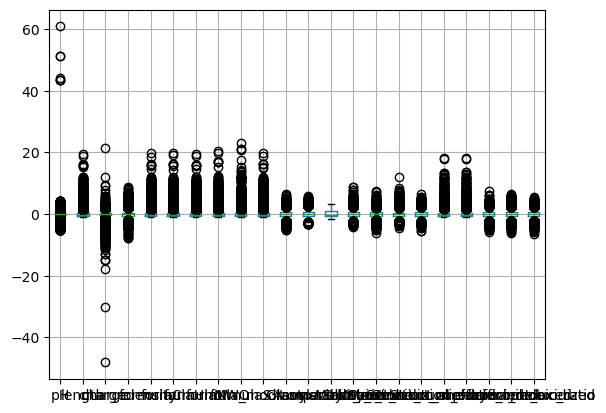

In [224]:
#boxplots para cada variável continua
#o objetivo é perceber se os valores são parecidos, se há outliers etc, devia ser feito individualmente para cada variável e com mais detalhe (mas também já temos os dados sumariados com os valores dos quartis)

#depois da reunião, a angelina escreveu isto (não percebemos)
#aplicar o package pip install git+https://github.com/jcapels/propythia.git@fix_dependencies para obter descritores fisico-químicos -> para correlações, etc. se valores fora de gama para os modelos (no random forest não é importante, mas modelos lineares é) usar sealers

data_scale_X.boxplot()
#atenção: confirmar que o bloxplot não inclui a variavel "seq_id"

                  Y
count  28739.000000
mean      49.350659
std       13.731283
min        0.000000
25%       42.300000
50%       48.000000
75%       53.500000
max      130.000000


Y_categorical
baixo      16341
elevado    12398
dtype: int64

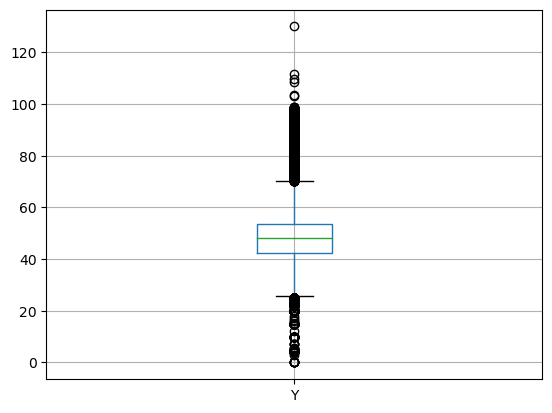

In [209]:
#analisar os valores de tm (o nosso Y), de forma a criar a partir dessa uma outra variável, mas desta vez categórica / qualitativa classificando em "tm baixo" ou "tm alto" consoante os valores de tm
summary = data_Y.describe() #data_Y é pandas dataframe
print(summary)
data_Y.boxplot()

Y_categorical = Y.copy() #copia para não alterar Y (nota Y é array)
mean = Y_categorical.mean()
median = Y_categorical.median()

#criar variavel categorica dividindo os valores de tm de acordo com média
Y_categorical[Y_categorical>mean]="elevado"
Y_categorical[Y_categorical!="elevado"]="baixo"
Y_categorical #Y_categorical é array / panda series

#converter o array / panda series em pandas dataframe pois às vezes dá mais jeito estar neste formato
data_Y_categorical = Y_categorical.to_frame(name = "Y_categorical")
data_Y_categorical

#frequencia de cada categoria
data_Y_categorical.groupby("Y_categorical").size()

In [ ]:
#com essas categorias, tentar encontrar correlações da tm (baixo/alto) com as outras variáveis continuas do X
#penso que talvez possa ser um "t test" independente às médias dos dois grupos (tm baixo / alto) ou equivalente

#A pergunta é: quais as variáveis que têm valores significativamente diferentes entre os dois grupos: tm alto e tm baixo


In [ ]:
#################################################
#################################################
#################################################

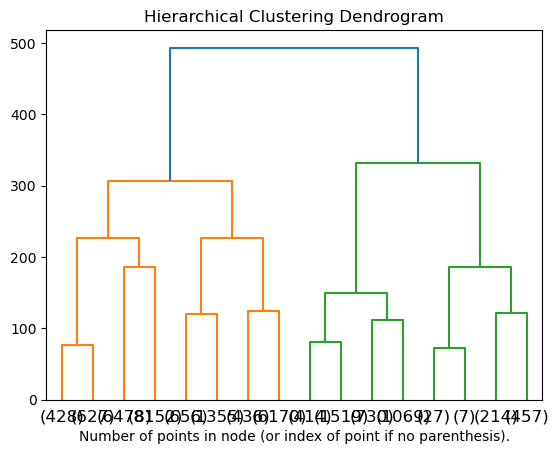

In [187]:
#clustering hierárquico - CODIGO COPIADO DO SCIKIT - WARNING demora muito a correr

import numpy as np
from matplotlib import pyplot as plt
from scipy.cluster.hierarchy import dendrogram
from sklearn.cluster import AgglomerativeClustering

def plot_dendrogram(model, **kwargs):
    # Create linkage matrix and then plot the dendrogram
    # create the counts of samples under each node
    counts = np.zeros(model.children_.shape[0])
    n_samples = len(model.labels_)
    for i, merge in enumerate(model.children_):
        current_count = 0
        for child_idx in merge:
            if child_idx < n_samples:
                current_count += 1  # leaf node
            else:
                current_count += counts[child_idx - n_samples]
        counts[i] = current_count
    linkage_matrix = np.column_stack(
        [model.children_, model.distances_, counts]
    ).astype(float)
    # Plot the corresponding dendrogram
    dendrogram(linkage_matrix, **kwargs)

# setting distance_threshold=0 ensures we compute the full tree.
model = AgglomerativeClustering(distance_threshold=0, n_clusters=None)

model = model.fit(data_scale_X)
plt.title("Hierarchical Clustering Dendrogram")
# plot the top three levels of the dendrogram
plot_dendrogram(model, truncate_mode="level", p=3)
plt.xlabel("Number of points in node (or index of point if no parenthesis).")
plt.show()

#ALTERAR FORMATAÇÃO (ver aqui: https://docs.scipy.org/doc/scipy/reference/generated/scipy.cluster.hierarchy.dendrogram.html )
# COMO INTERPRETAR? Era giro tentar se perceber se os dois grandes clusters correspondem a tm alto / baixo

In [278]:
#clustering hierarquico (2a tentativa) - WARNING demora muito a correr
from sklearn.cluster import AgglomerativeClustering

hclust = AgglomerativeClustering(n_clusters=2, affinity="euclidean", linkage="ward")
hclust.fit(data_scale_X)
res_hc = hclust.labels_
pd.crosstab(data_Y_categorical["Y_categorical"], res_hc)

col_0,0,1
Y_categorical,,
baixo,3032,13309
elevado,1405,10993


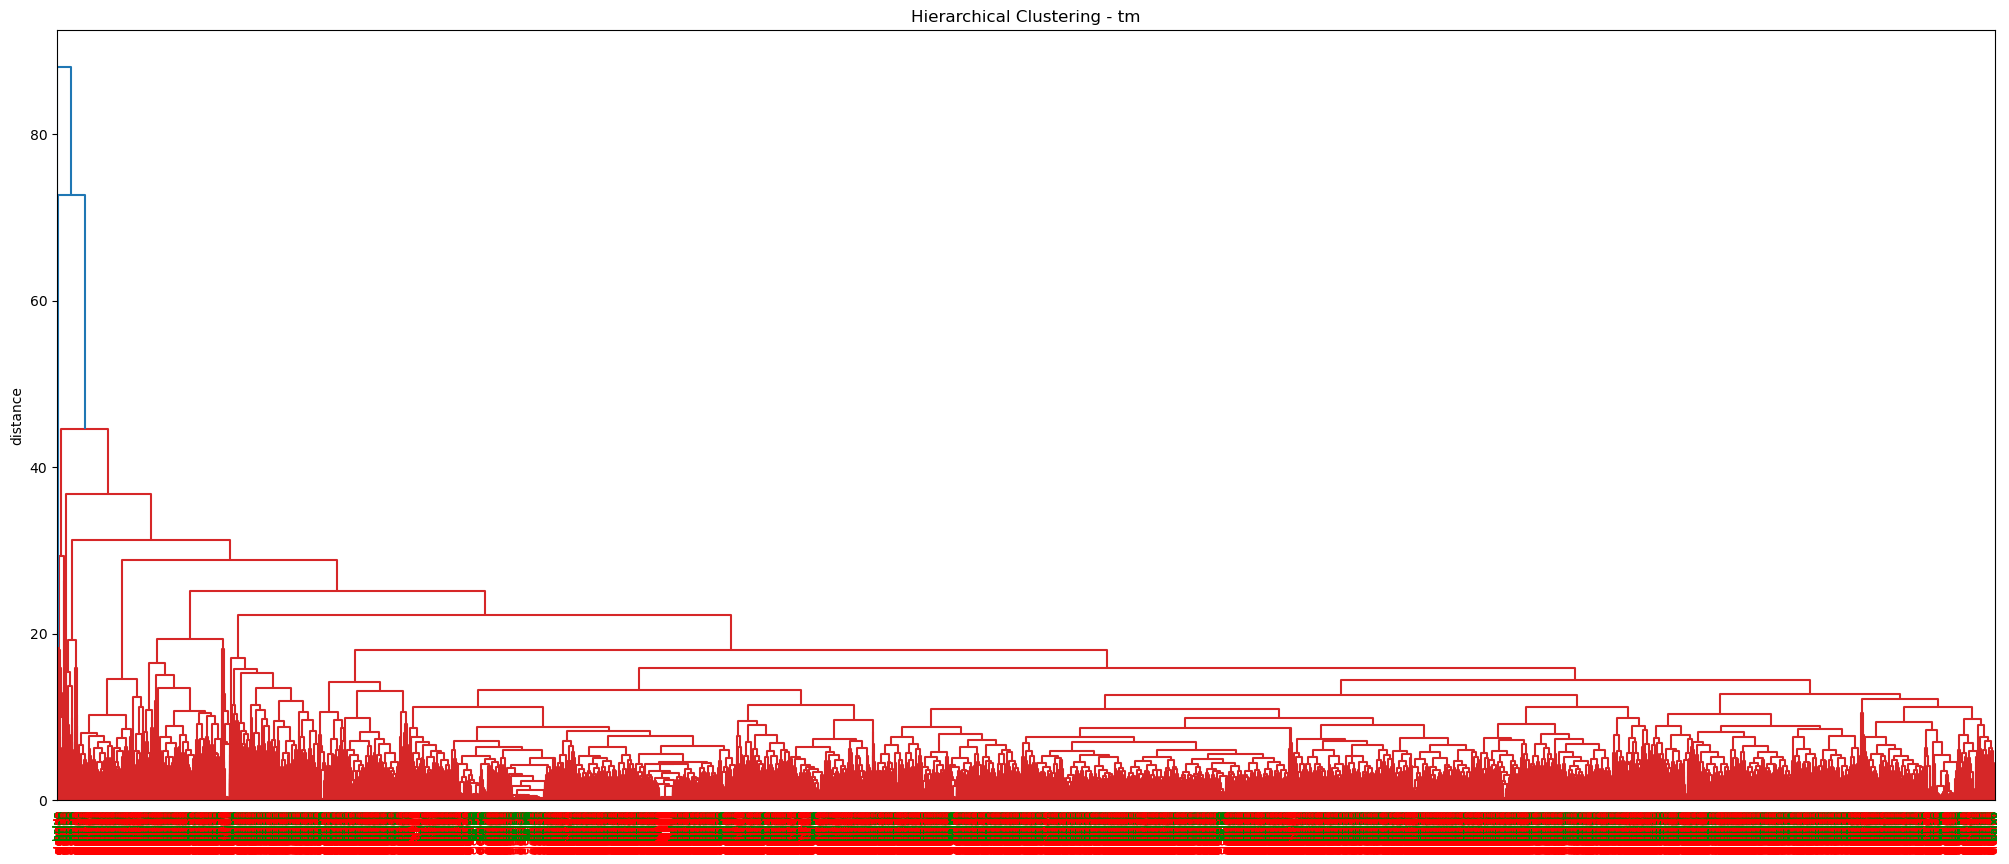

In [279]:
#clustering hierarquico (2a tentativa) - WARNING demora muito a correr

from scipy.cluster.hierarchy import dendrogram, linkage

Z = linkage(data_scale_X, method='complete', metric='euclidean')

# calculate full dendrogram
plt.figure(figsize=(25, 10))
dendrogram(
    Z,
    labels=list(data_Y_categorical["Y_categorical"]),
    leaf_rotation=90.,  # rotates the x axis labels
    leaf_font_size=8.,  # font size for the x axis labels
)

plt.title('Hierarchical Clustering - tm')
plt.ylabel('distance')


# Assignment of colors to labels: 'a' is red, 'b' is green, etc.
label_colors = {'elevado': 'r', 'baixo': 'g'}
ax = plt.gca()
xlbls = ax.get_xmajorticklabels()
for lbl in xlbls:
    lbl.set_color(label_colors[lbl.get_text()])

plt.show()


In [274]:
#clustering kmeans
from sklearn.cluster import KMeans
import numpy as np

k=2 #valor inicial arbitrário, depois experimentar mesmo codigo com k=3 e k=10
kmeans_dataset = KMeans(n_clusters=k, max_iter=1000)
kmeans_dataset.fit(data_scale_X)
kmeans_dataset.predict(data_scale_X)
labels = kmeans_dataset.labels_
print(labels)
centroids = kmeans_dataset.cluster_centers_
print(centroids)

pd.crosstab(labels,data_Y_categorical["Y_categorical"], rownames=['clusters'] )

#gráficos dão sempre erro, mas poderia ser importante aqui como estratégia para VISUALIZAR DADOS
#se não conseguirmos gráficos, pelo menos tentar INTERPRETAR TABELA


[0 0 0 ... 0 0 0]
[[ 1.425e-03 -2.397e-01  1.097e-01  2.645e-02 -2.396e-01 -2.393e-01
  -2.403e-01 -2.396e-01 -2.158e-01 -2.400e-01  5.009e-02  3.206e-02
   2.928e-02 -6.766e-02  5.103e-02 -3.434e-02  1.328e-02 -2.053e-01
  -2.058e-01  4.088e-02 -4.840e-02  5.551e-02]
 [-1.329e-02  2.235e+00 -1.023e+00 -2.467e-01  2.235e+00  2.232e+00
   2.241e+00  2.235e+00  2.012e+00  2.238e+00 -4.671e-01 -2.990e-01
  -2.731e-01  6.310e-01 -4.760e-01  3.203e-01 -1.238e-01  1.915e+00
   1.919e+00 -3.813e-01  4.514e-01 -5.177e-01]]


Y_categorical,baixo,elevado
clusters,,
0,14400,11560
1,1941,838


In [271]:
#pca
from sklearn.decomposition import PCA

pca_cach = PCA(n_components=3) #experimentar alterar
pca_cach.fit(data_scale_X)
X_r = pca_cach.transform(data_scale_X) # transformacao dos dados no novo espaço utilizando apenas 5 CP
print('Var. explicada: %s'% str(pca_cach.explained_variance_ratio_))
print('Soma:', sum(pca_cach.explained_variance_ratio_) * 100, "%")

Var. explicada: [0.403 0.204 0.105]
Soma: 71.20189605367919 %


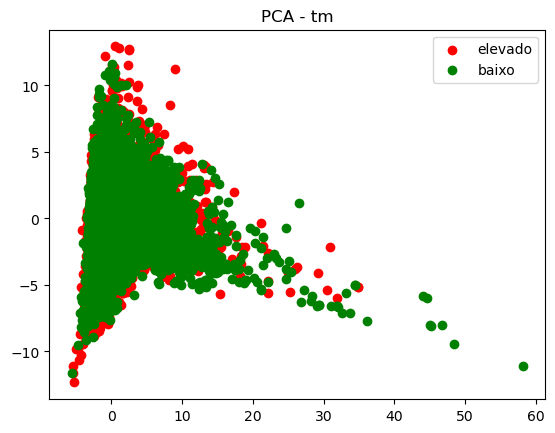

In [276]:
meta_values = data_Y_categorical["Y_categorical"]
plt.figure()
for c, name in zip("rgb", ["elevado", "baixo"]):
    plt.scatter(X_r[meta_values == name, 0], X_r[meta_values == name, 1], c=c, label=name)
plt.legend()
plt.title('PCA - tm')
plt.show()

#INTERPRETAR, experimentar diferentes n

C:\Users\sonia\anaconda3\envs\SIB\lib\site-packages\sklearn\manifold\_t_sne.py:800: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
C:\Users\sonia\anaconda3\envs\SIB\lib\site-packages\sklearn\manifold\_t_sne.py:810: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


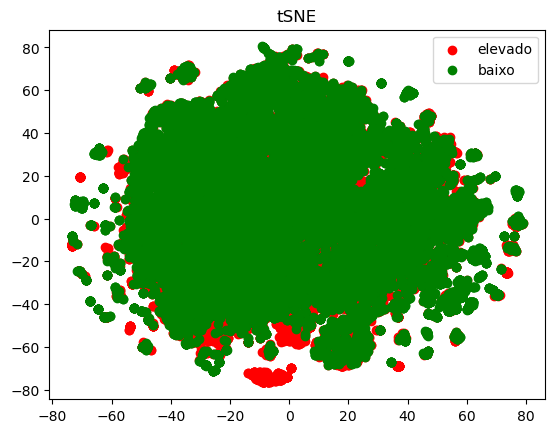

In [277]:
#tSNE
from sklearn.manifold import TSNE

tsne = TSNE(n_components=2, n_iter=1000)
points = tsne.fit_transform(data_scale_X)
meta_values = data_Y_categorical["Y_categorical"]

plt.figure()
for c, name in zip("rgb", ["elevado", "baixo"]):
    plt.scatter(points[meta_values == name, 0], points[meta_values == name, 1], c=c, label=name)
plt.title("tSNE")
plt.legend(loc='best', shadow=False)
plt.show()

#INTERPRETAR, alterar n_components
